# 0-Libraries

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report,ConfusionMatrixDisplay, balanced_accuracy_score
#from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler, QuantileTransformer, PowerTransformer
import tensorflow as tf
from tensorflow import keras
from keras import regularizers
from keras.optimizers import Adam
#from keras.backend import expand_dims
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Sequential
from keras.constraints import MaxNorm
from keras.layers import Activation, Dense, Conv1D, Flatten, MaxPooling1D, Dropout, BatchNormalization, SpatialDropout1D

In [5]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

# 1- Load Data

In [6]:
s_aureus = pd.read_csv('e_coli_driams_b_2000_20000Da_v2 (1).csv')
s_aureus.head()

,2000,2003,2006,2009,2012,2015,2018,2021,2024,2027,...,19988,19991,19994,19997,code,species,Ciprofloxacin,Ceftriaxone,Cefepime,Piperacillin-Tazobactam
0,1067.142857,1251.714286,1310.571429,1021.142857,1315.625000,974.000000,936.857143,853.571429,936.142857,1044.285714,...,21.5,6.500000,4.666667,17.585859,dcd5aa31-b254-4961-b69f-ccc8c0572b27,Escherichia coli,0.0,0.0,0.0,0.0
1,1872.857143,1677.285714,2035.714286,2086.250000,1930.571429,2017.142857,1856.857143,1655.857143,1547.142857,1713.000000,...,21.0,15.000000,26.500000,21.736842,dfcb7221-e4f8-4a39-b661-7e439f19e93d,Escherichia coli,0.0,0.0,0.0,0.0
2,3258.142857,3209.428571,3068.571429,3162.428571,3275.000000,3324.571429,2999.000000,2970.500000,3213.000000,3205.571429,...,17.0,17.000000,30.000000,19.125000,d5bb4389-5053-4107-9c05-bfed9e9159c9,Escherichia coli,0.0,0.0,0.0,0.0
3,18912.571429,19530.571429,19464.875000,19098.714286,18994.714286,18936.285714,19208.571429,19417.571429,19486.857143,19048.625000,...,299.0,339.500000,359.000000,311.746032,4e14943f-ae22-42ed-aef5-65430470dcfa,Escherichia coli,0.0,0.0,0.0,0.0
4,1685.000000,1537.428571,1283.714286,1472.285714,1370.142857,1402.142857,1397.500000,1422.142857,1725.285714,3386.714286,...,32.5,48.333333,66.500000,39.230769,617f14d0-86b1-4c28-8995-b02006a85e81,Escherichia coli,1.0,1.0,1.0,1.0


# Preprocessing Data

In [7]:
s_aureus = s_aureus.drop(columns=['code','species', 'Ceftriaxone', 'Cefepime', 'Piperacillin-Tazobactam'])
s_aureus.dropna(axis=0, how="any", inplace=True)

In [8]:
s_aureus.head()

,2000,2003,2006,2009,2012,2015,2018,2021,2024,2027,...,19973,19976,19979,19982,19985,19988,19991,19994,19997,Ciprofloxacin
0,1067.142857,1251.714286,1310.571429,1021.142857,1315.625000,974.000000,936.857143,853.571429,936.142857,1044.285714,...,19.666667,20.000000,23.0,42.666667,15.000000,21.5,6.500000,4.666667,17.585859,0.0
1,1872.857143,1677.285714,2035.714286,2086.250000,1930.571429,2017.142857,1856.857143,1655.857143,1547.142857,1713.000000,...,32.000000,29.666667,30.0,18.000000,17.000000,21.0,15.000000,26.500000,21.736842,0.0
2,3258.142857,3209.428571,3068.571429,3162.428571,3275.000000,3324.571429,2999.000000,2970.500000,3213.000000,3205.571429,...,19.666667,20.000000,23.5,14.500000,13.666667,17.0,17.000000,30.000000,19.125000,0.0
3,18912.571429,19530.571429,19464.875000,19098.714286,18994.714286,18936.285714,19208.571429,19417.571429,19486.857143,19048.625000,...,299.000000,269.333333,282.0,300.500000,311.000000,299.0,339.500000,359.000000,311.746032,0.0
4,1685.000000,1537.428571,1283.714286,1472.285714,1370.142857,1402.142857,1397.500000,1422.142857,1725.285714,3386.714286,...,25.000000,34.000000,33.0,37.333333,21.000000,32.5,48.333333,66.500000,39.230769,1.0


In [9]:
bacteria = s_aureus.columns[-1]

In [10]:
print('clase minoritaria',s_aureus[s_aureus[bacteria] == 1].shape[0])
print('clase mayoritaria',s_aureus[s_aureus[bacteria] == 0].shape[0])

clase minoritaria 59
clase mayoritaria 154


In [11]:
X = s_aureus.iloc[:, 0:6000].values  # variables independientes (espectros de masa)
y = s_aureus.iloc[:, 6000].values    # variable dependientes (resistencia a ciprofloxacin)
X = np.asarray(X).astype(np.float32)
y = np.asarray(y).astype(np.float32)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify=y)

In [13]:
X_train.shape

(170, 6000)

## Enfoque en clase minoritaria

In [14]:
minority_class = s_aureus[s_aureus[bacteria] == 1].drop(columns=[bacteria])


In [15]:
minority_class.head()

,2000,2003,2006,2009,2012,2015,2018,2021,2024,2027,...,19970,19973,19976,19979,19982,19985,19988,19991,19994,19997
4,1685.000000,1537.428571,1283.714286,1472.285714,1370.142857,1402.142857,1397.500000,1422.142857,1725.285714,3386.714286,...,38.333333,25.000000,34.000000,33.000000,37.333333,21.0,32.500000,48.333333,66.500000,39.230769
6,2609.857143,2827.714286,2829.285714,2664.375000,2552.714286,2823.285714,2694.571429,2847.285714,2661.571429,2544.285714,...,114.000000,112.000000,132.333333,97.500000,113.000000,151.0,108.666667,113.000000,88.000000,97.010309
21,2461.714286,2371.875000,3136.000000,2858.142857,2427.571429,2449.714286,2436.285714,2194.125000,2246.428571,2538.714286,...,156.500000,163.333333,177.000000,182.500000,154.500000,172.0,182.500000,152.500000,125.500000,156.954955
23,2263.142857,2272.428571,2201.428571,2340.571429,1961.000000,2168.285714,2264.142857,2209.000000,2118.000000,2267.571429,...,12.500000,7.333333,2.000000,11.500000,19.333333,9.0,6.000000,15.000000,5.333333,10.547170
24,4392.142857,4385.857143,4368.000000,4249.714286,4252.142857,4330.285714,4398.250000,4322.285714,4141.428571,4183.285714,...,19.000000,21.000000,6.000000,15.333333,6.000000,6.0,24.333333,5.000000,18.000000,13.500000


In [17]:
from sdv.metadata import SingleTableMetadata

# Crear un objeto Metadata para el dataset
metadata = SingleTableMetadata()

# Detectar automáticamente los tipos de datos del DataFrame
metadata.detect_from_dataframe(minority_class)

# Visualizar el metadata generado
print(metadata.to_dict())

{'columns': {'2000': {'sdtype': 'numerical'}, '2003': {'sdtype': 'numerical'}, '2006': {'sdtype': 'numerical'}, '2009': {'sdtype': 'numerical'}, '2012': {'sdtype': 'numerical'}, '2015': {'sdtype': 'numerical'}, '2018': {'sdtype': 'numerical'}, '2021': {'sdtype': 'numerical'}, '2024': {'sdtype': 'numerical'}, '2027': {'sdtype': 'numerical'}, '2030': {'sdtype': 'numerical'}, '2033': {'sdtype': 'numerical'}, '2036': {'sdtype': 'numerical'}, '2039': {'sdtype': 'numerical'}, '2042': {'sdtype': 'numerical'}, '2045': {'sdtype': 'numerical'}, '2048': {'sdtype': 'numerical'}, '2051': {'sdtype': 'numerical'}, '2054': {'sdtype': 'numerical'}, '2057': {'sdtype': 'numerical'}, '2060': {'sdtype': 'numerical'}, '2063': {'sdtype': 'numerical'}, '2066': {'sdtype': 'numerical'}, '2069': {'sdtype': 'numerical'}, '2072': {'sdtype': 'numerical'}, '2075': {'sdtype': 'numerical'}, '2078': {'sdtype': 'numerical'}, '2081': {'sdtype': 'numerical'}, '2084': {'sdtype': 'numerical'}, '2087': {'sdtype': 'numerical'

In [18]:
from sdv.single_table import GaussianCopulaSynthesizer

synthesizer = GaussianCopulaSynthesizer(metadata)

/home/hpinto/.local/lib/python3.9/site-packages/sdv/single_table/base.py:119: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/home/hpinto/.local/lib/python3.9/site-packages/sdv/single_table/base.py:104: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


In [19]:
synthesizer.fit(
    data=minority_class
)




In [20]:
s_aureus[s_aureus[bacteria] == 0].shape[0]-s_aureus[s_aureus[bacteria] == 1].shape[0]

95

In [21]:
synthetic_data = synthesizer.sample(
    pd.Series(y_train).value_counts()[0]-pd.Series(y_train).value_counts()[1]
)

In [22]:
synthetic_data.shape

(76, 6000)

In [23]:

# Cambiar el tipo de datos a float32
synthetic_samples_numpy_copula = synthetic_data.astype(np.float32)

# Mostrar las muestras generadas
synthetic_samples_numpy_copula.shape

(76, 6000)

In [24]:
X_train_resampled = np.concatenate([X_train,synthetic_samples_numpy_copula])

In [25]:
s_aureus[s_aureus[bacteria] == 0].shape

(154, 6001)

In [26]:
X_train.shape

(170, 6000)

In [27]:
int((pd.Series(y_train).value_counts()[0]-pd.Series(y_train).value_counts()[1]))

76

In [28]:
ones_array = np.ones(int((pd.Series(y_train).value_counts()[0]-pd.Series(y_train).value_counts()[1])))
y_train_resampled = np.concatenate([y_train,ones_array])
y_train_resampled.shape

(246,)

In [29]:
print(pd.Series(y_train_resampled).value_counts())


0.0    123
1.0    123
Name: count, dtype: int64


In [30]:
scaler=Normalizer(norm='max')
sc_X = scaler
X_train = sc_X.fit_transform(X_train_resampled)
X_test = sc_X.transform(X_test)

In [31]:
sample_size = X_train.shape[0] # numero de muestras en el set de datos
time_steps  = X_train.shape[1] # numero de atributos en el set de datos
input_dimension = 1            #

X_train_reshaped = X_train.reshape(sample_size,time_steps,input_dimension)
X_test_reshaped = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [32]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.000001)
early_st = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

n_timesteps = X_train_reshaped.shape[1] #
n_features  = X_train_reshaped.shape[2] #

# Create and fit DeepAMR model

In [33]:
model = Sequential(name="Modelo_s_aureus_ciprofloxacin")
init_mode = 'normal'
model.add(Conv1D(filters=(64), kernel_size=(17), input_shape = (n_timesteps,n_features), name='Conv_1'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2, name="MaxPooling1D_1"))

model.add(Conv1D(filters=(128), kernel_size=(9),kernel_initializer=init_mode, kernel_regularizer=regularizers.l2(0.0001),  name='Conv_2'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2, name="MaxPooling1D_2"))

model.add(Conv1D(filters=(256), kernel_size=(5),kernel_initializer=init_mode,kernel_regularizer=regularizers.l2(0.0001),   name='Conv_3'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2, name="MaxPooling1D_3"))

model.add(Conv1D(filters=(256), kernel_size=(5),kernel_initializer=init_mode, kernel_regularizer=regularizers.l2(0.0001),   name='Conv_4'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2, name="MaxPooling1D_4"))

model.add(Flatten())
model.add(Dropout(0.65))
model.add(Dense(256, activation='relu',kernel_initializer=init_mode, kernel_regularizer=regularizers.l2(0.0001), name="fully_connected_0"))
model.add(Dense(64, activation='relu',kernel_initializer=init_mode, kernel_regularizer=regularizers.l2(0.0001), name="fully_connected_1"))
model.add(Dense(64, activation='relu',kernel_initializer=init_mode, kernel_regularizer=regularizers.l2(0.0001),  name="fully_connected_2"))
model.add(Dense(n_features, activation='sigmoid', name="OUT_Layer"))

model.compile(optimizer = Adam(learning_rate=0.0001), loss = 'binary_crossentropy',  metrics=METRICS)
model.summary()

Model: "Modelo_s_aureus_ciprofloxacin"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv_1 (Conv1D)             (None, 5984, 64)          1152      
                                                                 
 batch_normalization (BatchN  (None, 5984, 64)         256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 5984, 64)          0         
                                                                 
 MaxPooling1D_1 (MaxPooling1  (None, 2992, 64)         0         
 D)                                                              
                                                                 
 Conv_2 (Conv1D)             (None, 2984, 128)         73856     
                                                                 
 batch_normalization_1 (Batc  (None, 

In [34]:
history = model.fit(X_train_reshaped, y_train_resampled, epochs=100, batch_size=10, verbose=1, validation_split=0.1, callbacks=[reduce_lr,early_st])

Epoch 1/100


2025-01-19 13:56:29.347752: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8907
2025-01-19 13:56:29.371023: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-01-19 13:56:30.236017: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


23/23 [==============================] - 4s 61ms/step - loss: 7.3596 - tp: 39.0000 - fp: 60.0000 - tn: 63.0000 - fn: 59.0000 - accuracy: 0.4615 - precision: 0.3939 - recall: 0.3980 - auc: 0.4572 - prc: 0.4227 - val_loss: 6.7834 - val_tp: 25.0000 - val_fp: 0.0000e+00 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 0.0000e+00 - val_prc: 1.0000 - lr: 1.0000e-04
Epoch 2/100
23/23 [==============================] - 1s 31ms/step - loss: 6.8439 - tp: 55.0000 - fp: 45.0000 - tn: 78.0000 - fn: 43.0000 - accuracy: 0.6018 - precision: 0.5500 - recall: 0.5612 - auc: 0.6237 - prc: 0.5752 - val_loss: 6.7852 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 0.0000e+00 - val_fn: 25.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.0000e+00 - val_prc: 1.0000 - lr: 1.0000e-04
Epoch 3/100
23/23 [==============================] - 1s 34ms/step - loss: 6.7757 - tp: 53.0000 - fp: 46.0000

# Evaluate the model

In [35]:
y_pred  = model.predict(X_test_reshaped)
y_pred = (y_pred>0.5)
cm = confusion_matrix(y_test, y_pred)
print(cm)

2/2 [==============================] - 0s 30ms/step
[[26  5]
 [ 6  6]]


In [36]:
print("balanced acuracy:", balanced_accuracy_score(y_test, y_pred))

balanced acuracy: 0.6693548387096775


In [37]:
target_names=["0","1"]
print(classification_report(y_test, y_pred, target_names=target_names))

train_predictions_baseline = model.predict(X_train_reshaped, batch_size=10)
test_predictions_baseline = model.predict(X_test_reshaped, batch_size=10)

baseline_results = model.evaluate(X_test_reshaped, y_test, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

              precision    recall  f1-score   support

           0       0.81      0.84      0.83        31
           1       0.55      0.50      0.52        12

    accuracy                           0.74        43
   macro avg       0.68      0.67      0.67        43
weighted avg       0.74      0.74      0.74        43

5/5 [==============================] - 0s 8ms/step
loss :  5.728062629699707
tp :  6.0
fp :  5.0
tn :  26.0
fn :  6.0
accuracy :  0.7441860437393188
precision :  0.5454545617103577
recall :  0.5
auc :  0.6841397881507874
prc :  0.554629385471344



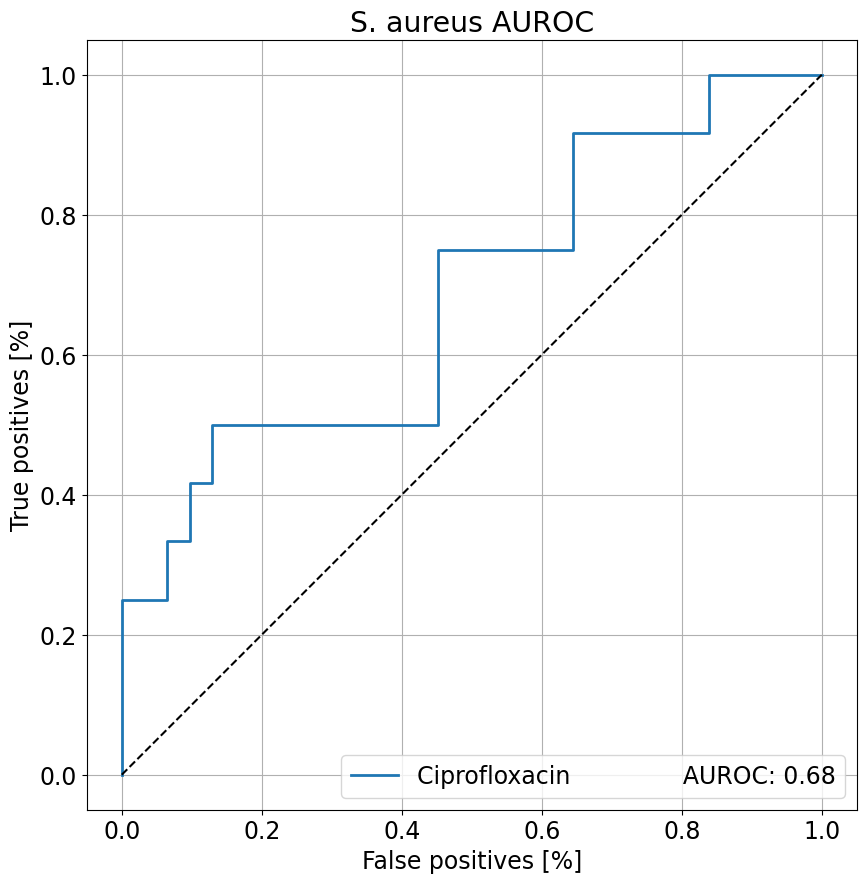

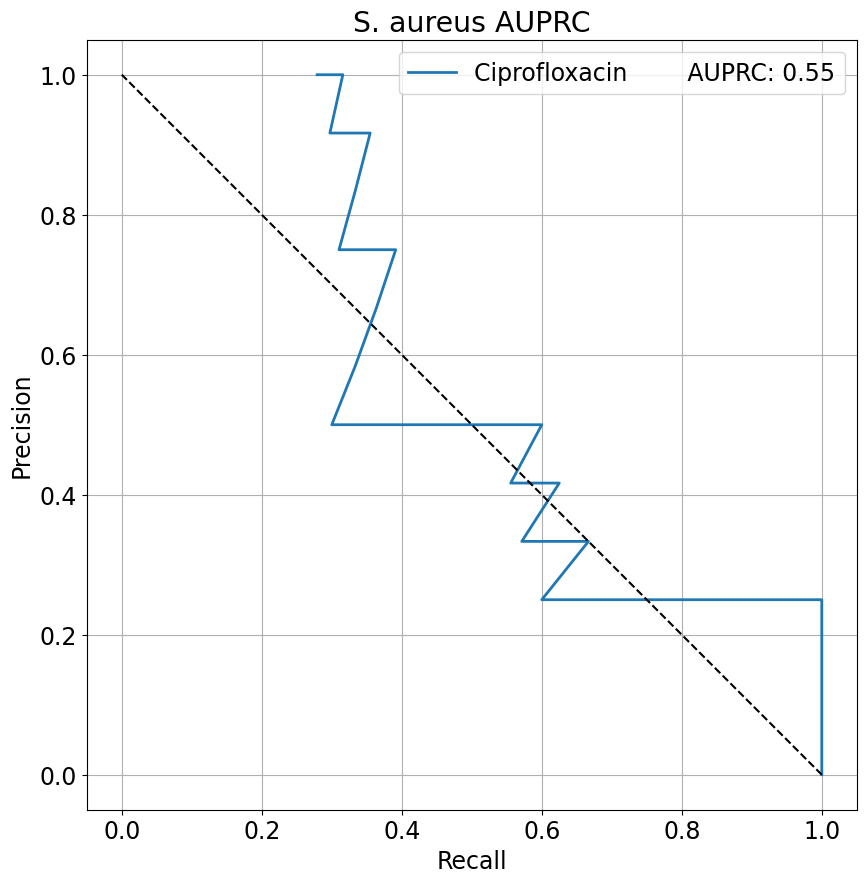

In [38]:
plt.rcParams['figure.figsize'] = (12, 10)
plt.rcParams.update({'font.size': 17})
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(fp, tp, label=name, linewidth=2, **kwargs)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.title('E. coli CNN')
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.title('S. aureus AUROC')

  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')
plot_roc("Ciprofloxacin               AUROC: %0.2f" % baseline_results[8], y_test, test_predictions_baseline, color=colors[0])

plt.legend(loc='lower right')
plt.savefig('s_aureus_auroc.png', bbox_inches='tight')
plt.show()

def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.title('S. aureus AUPRC')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.plot([1, 0], [0, 1], 'k--')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

plot_prc("Ciprofloxacin        AUPRC: %0.2f" % baseline_results[9], y_test, test_predictions_baseline, color=colors[0])

plt.legend(loc='upper right')
plt.savefig('s_aureus_auprc.png', bbox_inches='tight')
plt.show()